# Data Preparation

In [4]:
import tarfile

# Replace 'file.tar' with the name of your tar file
# Replace 'my/directory' with the path to the directory where you want to extract the archive
with tarfile.open('weather.tar', 'r') as tar:
    tar.extractall()

In [51]:
import os
import random
import shutil

def split_dataset(root_dir, output_dir, split_ratio=(0.8, 0.1, 0.1)):
    """
    Splits a dataset into train, validation, and test sets.

    Args:
        root_dir (str): path to the root dataset directory.
        output_dir (str): path to the output directory where the split dataset will be saved.
        split_ratio (tuple): a tuple of three floats representing the ratio of train, validation, and test sets respectively.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    weather_types = ['brightness', 'fog', 'frost', 'snow']
    for weather in weather_types:
        weather_dir = os.path.join(root_dir, weather)
        level_dirs = [os.path.join(weather_dir, str(i)) for i in range(1, 6)]
        for level_dir in level_dirs:
            subdirs = [d for d in os.listdir(level_dir) if os.path.isdir(os.path.join(level_dir, d)) and d.startswith('n')]
            for subdir in subdirs:
                image_dir = os.path.join(level_dir, subdir)
                images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.JPEG')]
                random.shuffle(images)
                num_images = len(images)
                num_train = int(num_images * split_ratio[0])
                num_val = int(num_images * split_ratio[1])
                num_test = num_images - num_train - num_val
                train_images = images[:num_train]
                val_images = images[num_train:num_train+num_val]
                test_images = images[num_train+num_val:]

                train_dir = os.path.join(output_dir, 'train', weather, os.path.basename(level_dir), subdir)
                val_dir = os.path.join(output_dir, 'val', weather, os.path.basename(level_dir), subdir)
                test_dir = os.path.join(output_dir, 'test', weather, os.path.basename(level_dir), subdir)

                for dir_path in [train_dir, val_dir, test_dir]:
                    if not os.path.exists(dir_path):
                        os.makedirs(dir_path)

                for img_path in train_images:
                    shutil.copy(img_path, os.path.join(train_dir, os.path.basename(img_path)))
                for img_path in val_images:
                    shutil.copy(img_path, os.path.join(val_dir, os.path.basename(img_path)))
                for img_path in test_images:
                    shutil.copy(img_path, os.path.join(test_dir, os.path.basename(img_path)))

split_dataset('ImageNet', 'data')

In [144]:
import os
import shutil

root_dir = 'data/test'
weather_types = ['brightness', 'fog', 'frost', 'snow']

for weather in weather_types:
    weather_dir = os.path.join(root_dir, weather)
    level_dirs = [os.path.join(weather_dir, str(i)) for i in range(1, 6)]
    for level_dir in level_dirs:
        image_dirs = [os.path.join(level_dir, d) for d in os.listdir(level_dir) if os.path.isdir(os.path.join(level_dir, d))]
        for image_dir in image_dirs:
            if os.path.basename(image_dir).startswith('n'):
                images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.JPEG')]
                fog_dir = os.path.join(root_dir, weather)
                if not os.path.exists(fog_dir):
                    os.makedirs(fog_dir)
                for img_path in images:
                    shutil.move(img_path, os.path.join(fog_dir, os.path.basename(img_path)))
                os.rmdir(image_dir)

--------------
--------------
--------------
--------------


## import modules

In [16]:
from models_convmae import MaskedAutoencoderConvViT
from functools import partial
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.svm import LinearSVC
import models_convmae
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from vision_transformer import PatchEmbed, Block, CBlock
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import models_dmae
import models_mae
#import model_dcmae
import pytorch_ssim
from vision_transformer import PatchEmbed, Block, CBlock

from util.pos_embed import get_2d_sincos_pos_embed

imagenet_mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
imagenet_std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)


In [3]:
patch_embed3 = PatchEmbed(
        img_size=224, patch_size=16, in_chans=1024, embed_dim=1024)

def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_embed3.patch_size[0]
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

In [4]:
def show_image(image, title='', normalized=True):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    if normalized:  # unnormalization
        image = image * imagenet_std + imagenet_mean
    plt.imshow(torch.clip(image * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return
def run_one_image(img, model, sigma=0.25, mask_ratio=0.75):
    
    #noise = torch.randn_like(img) * sigma
    #perturbed_img = img + noise

    # make it a batch-like
    x = img.unsqueeze(dim=0)# perturbed_img.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    mean = torch.mean(x)
    std = torch.std(x)

    # normalize input data
    x = (x - mean) / std
    # run convMAE
    # x = (x - model.mean) / model.std
    latent, mask, ids_restore = model.forward_encoder(x.float(), mask_ratio)
    y = model.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
    loss = model.forward_loss(x, y, mask)

    y = unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, 16*16*3)  # (N, H*W, p*p*3)
    mask = unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = img * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask
    
    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(img, "original", normalized=False)

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked", normalized=False)

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")
    
    plt.show()

# load models

In [5]:
def prepare_model_convmae(chkpt_dir, arch='convmae_convvit_base_patch16'):
    # build model
    model = models_convmae.__dict__[arch]()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    #print("Load pre-trained checkpoint from: %s" % chkpt_dir)
    checkpoint_model = checkpoint['model']
    
    msg = model.load_state_dict(checkpoint_model, strict=False)

    print(msg)
    return model
chkpt_dir_convmae = 'convmae_base.pth'
model_convmae = prepare_model_convmae(chkpt_dir_convmae)
print('Model loaded.')


_IncompatibleKeys(missing_keys=['mask_token', 'decoder_pos_embed', 'stage1_output_decode.weight', 'stage1_output_decode.bias', 'stage2_output_decode.weight', 'stage2_output_decode.bias', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.f

In [27]:

def prepare_model_dmae(chkpt_dir, arch='dmae_vit_large_patch16'):
    # build model
    model = getattr(models_dmae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    print(checkpoint.keys())
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

chkpt_dir = 'dmae.pth'
model_dmae = prepare_model_dmae(chkpt_dir, 'dmae_vit_large_patch16')
print('Model loaded.')

dict_keys(['model'])
<All keys matched successfully>
Model loaded.


In [6]:
def prepare_model_mae(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model
chkpt_mae = 'mae_pretrain_vit_large.pth'
model_mae = prepare_model_mae(chkpt_mae, 'mae_vit_large_patch16')
print('Model loaded.')

_IncompatibleKeys(missing_keys=['mask_token', 'decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 'decoder_blocks.1.mlp.fc2.bias', 'decoder_blocks.2.norm1.weight', 'decoder_blocks.2.norm1.bias', 'decoder_bl

# load image

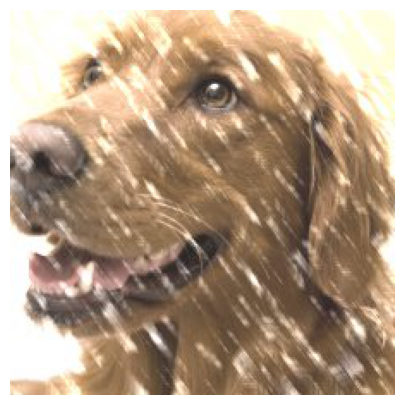

In [7]:
# load an image
img_path = 'data/val/snow/ILSVRC2012_val_00000224.JPEG' 
img = Image.open(img_path)
img = img.resize((224, 224))
img = torch.tensor(np.array(img) / 255.)

assert img.shape == (224, 224, 3)

plt.rcParams['figure.figsize'] = [5, 5]
show_image(img, normalized=False)

# fix the random seed: make random mask reproducible
torch.manual_seed(2)

sigma = 0.25  # noise scale
mask_ratio = 0.7


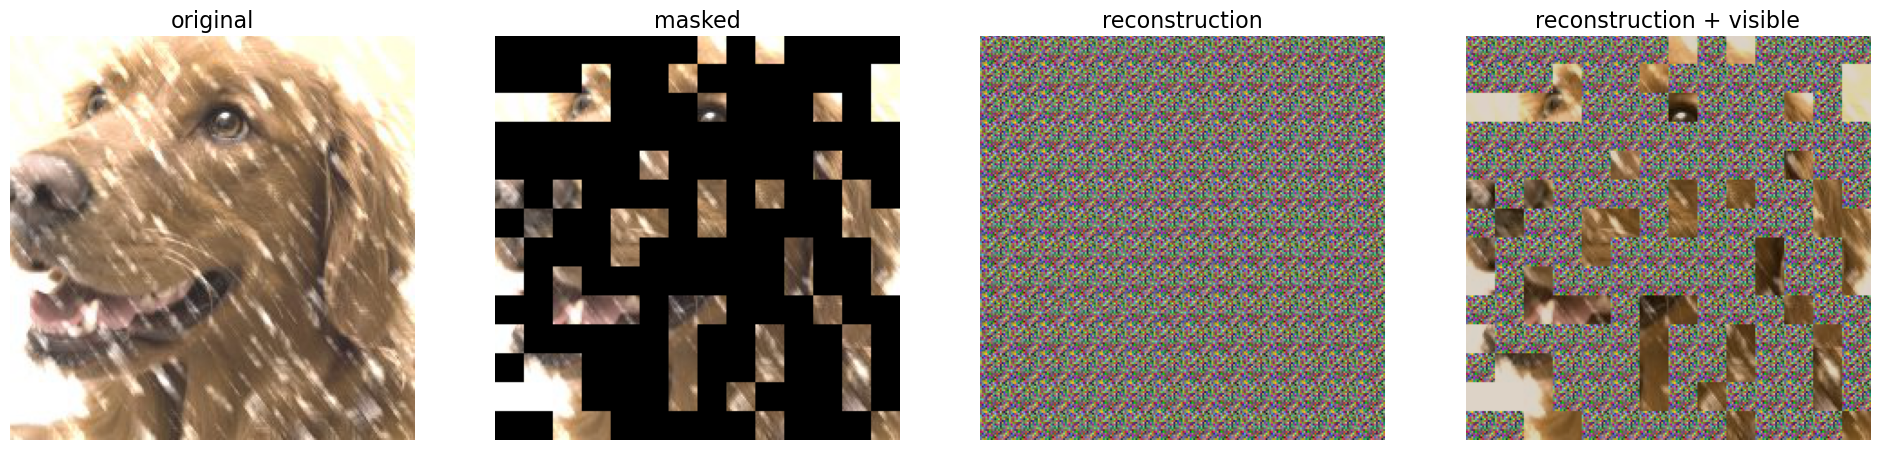

In [9]:
run_one_image(img,model_convmae , sigma=sigma, mask_ratio=mask_ratio)

In [34]:
from transformers import ViTModel
import PIL
class DCMAE:
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False,
                 sigma=0.5):
        super().__init__()

        self.model = model_dmae
        # the standard variance of noise
        self.sigma = sigma

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed1 = PatchEmbed(
                img_size=img_size[0], patch_size=patch_size[0], in_chans=in_chans, embed_dim=embed_dim[0])
        self.patch_embed2 = PatchEmbed(
                img_size=img_size[1], patch_size=patch_size[1], in_chans=embed_dim[0], embed_dim=embed_dim[1])
        self.patch_embed3 = PatchEmbed(
                img_size=img_size[2], patch_size=patch_size[2], in_chans=embed_dim[1], embed_dim=embed_dim[2])

        self.patch_embed4 = nn.Linear(embed_dim[2], embed_dim[2])
        self.stage1_output_decode = nn.Conv2d(embed_dim[0], embed_dim[2], 4, stride=4)
        self.stage2_output_decode = nn.Conv2d(embed_dim[1], embed_dim[2], 2, stride=2)
        num_patches = self.patch_embed3.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, *embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim[2]), requires_grad=False)

        self.blocks1 = nn.ModuleList([
            CBlock(
                dim=embed_dim[0], num_heads=num_heads, mlp_ratio=mlp_ratio[0],  qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth[0])])
        self.blocks2 = nn.ModuleList([
            CBlock(
                dim=embed_dim[1], num_heads=num_heads, mlp_ratio=mlp_ratio[1],  qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth[1])])
        self.blocks3 = nn.ModuleList([
            Block(
                dim=embed_dim[2], num_heads=num_heads, mlp_ratio=mlp_ratio[2],  qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth[2])])
        self.norm = norm_layer(embed_dim[-1])
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim[-1], decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding
        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio[0], qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, (patch_size[0] * patch_size[1] * patch_size[2])**2 * in_chans, bias=True) # decoder to patch
        #self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()
        
    def load_model(self) -> ViTModel:
        model = ViTModel.from_pretrained(self.checkpoint_path)
        model.eval()
        return model
    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed3.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed3.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed3.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

        # normalization parameters
        self.mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = 16
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed3.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1) # the order of elements

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        ids_keep, mask, ids_restore = self.random_masking(x, mask_ratio)
        mask_for_patch1 = mask.reshape(-1, 14, 14).unsqueeze(-1).repeat(1, 1, 1, 16).reshape(-1, 14, 14, 4, 4).permute(0, 1, 3, 2, 4).reshape(x.shape[0], 56, 56).unsqueeze(1)
        mask_for_patch2 = mask.reshape(-1, 14, 14).unsqueeze(-1).repeat(1, 1, 1, 4).reshape(-1, 14, 14, 2, 2).permute(0, 1, 3, 2, 4).reshape(x.shape[0], 28, 28).unsqueeze(1)
        x = self.patch_embed1(x)
        for blk in self.blocks1:
            x = blk(x, 1 - mask_for_patch1)
        stage1_embed = self.stage1_output_decode(x).flatten(2).permute(0, 2, 1)

        x = self.patch_embed2(x)
        for blk in self.blocks2:
            x = blk(x, 1 - mask_for_patch2)
        stage2_embed = self.stage2_output_decode(x).flatten(2).permute(0, 2, 1)
        x = self.patch_embed3(x)
        x = x.flatten(2).permute(0, 2, 1)
        x = self.patch_embed4(x)
        # add pos embed w/o cls token
        x = x + self.pos_embed
        x = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, x.shape[-1]))
        stage1_embed = torch.gather(stage1_embed, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, stage1_embed.shape[-1]))
        stage2_embed = torch.gather(stage2_embed, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, stage2_embed.shape[-1]))

        # apply Transformer blocks
        for blk in self.blocks3:
            x = blk(x)
        x = x + stage1_embed + stage2_embed
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        #loss = (pred - target) ** 2
        #loss = loss.mean()          # reconstruct and denoise all pixels

        loss = pytorch_ssim.ssim(pred, target, data_range = 1, size_average = False)
        loss = (1 - loss) / 2 # convert SSIM score to loss 
        
        loss = (loss * mask).sum() / mask.sum()  # mask loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        # add noise 
        noise = torch.randn_like(imgs) * self.sigma
        imgs_noised = imgs + noise
        imgs = transforms.Resize((224, 224), interpolation=PIL.Image.BICUBIC)(imgs)
        imgs_noised = transforms.Resize((224, 224), interpolation=PIL.Image.BICUBIC)(imgs_noised)

        # normalization
        if self.mean.device != imgs.device:
            self.mean = self.mean.to(imgs.device)
            self.std = self.std.to(imgs.device)
        imgs = (imgs - self.mean) / self.std
        imgs_noised = (imgs_noised - self.mean) / self.std

        latent, mask, ids_restore = self.forward_encoder(imgs_noised, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask


def dcmae_vit_base_patch16_dec512d8b(**kwargs):
    model = DCMAE(
        img_size=[224, 56, 28], patch_size=[4, 2, 2], embed_dim=[256, 384, 768], depth=[2, 2, 11], num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=[4, 4, 4], norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
dcmae_vit_base_patch16 = dcmae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
dcmae = dcmae_vit_base_patch16()
    

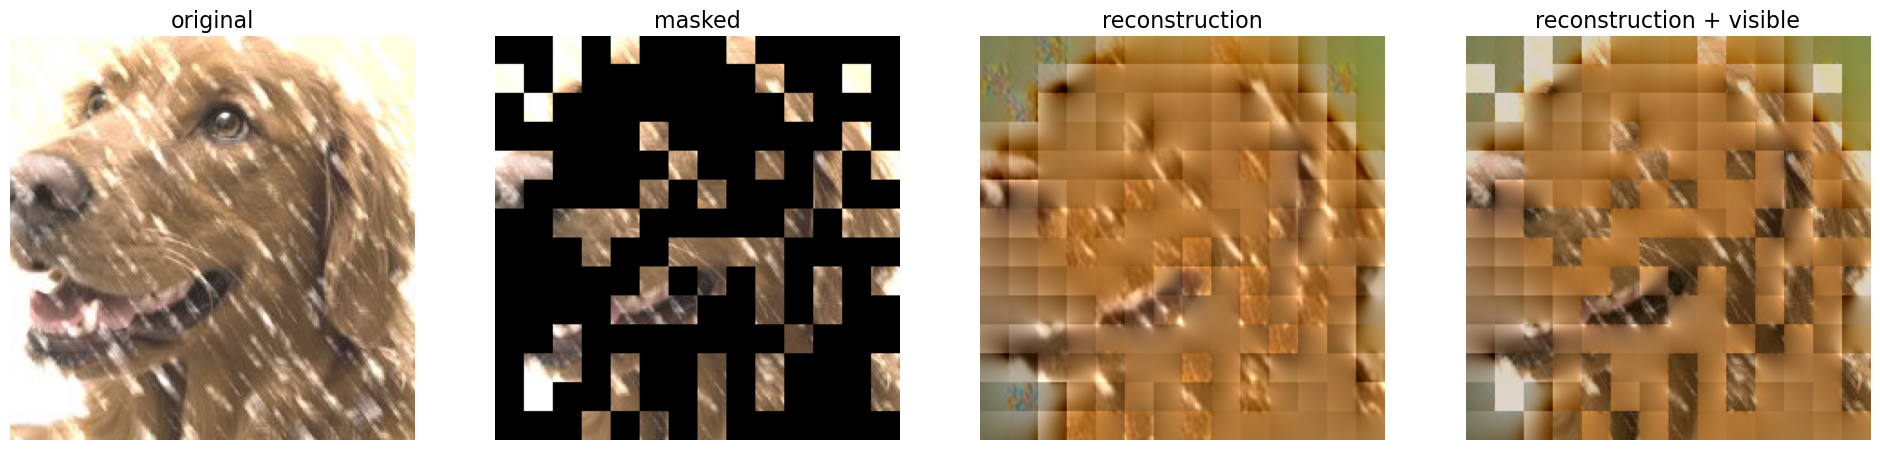

In [39]:
run_one_image(img, dcmae , sigma=sigma, mask_ratio=mask_ratio) #mae based reconstruction

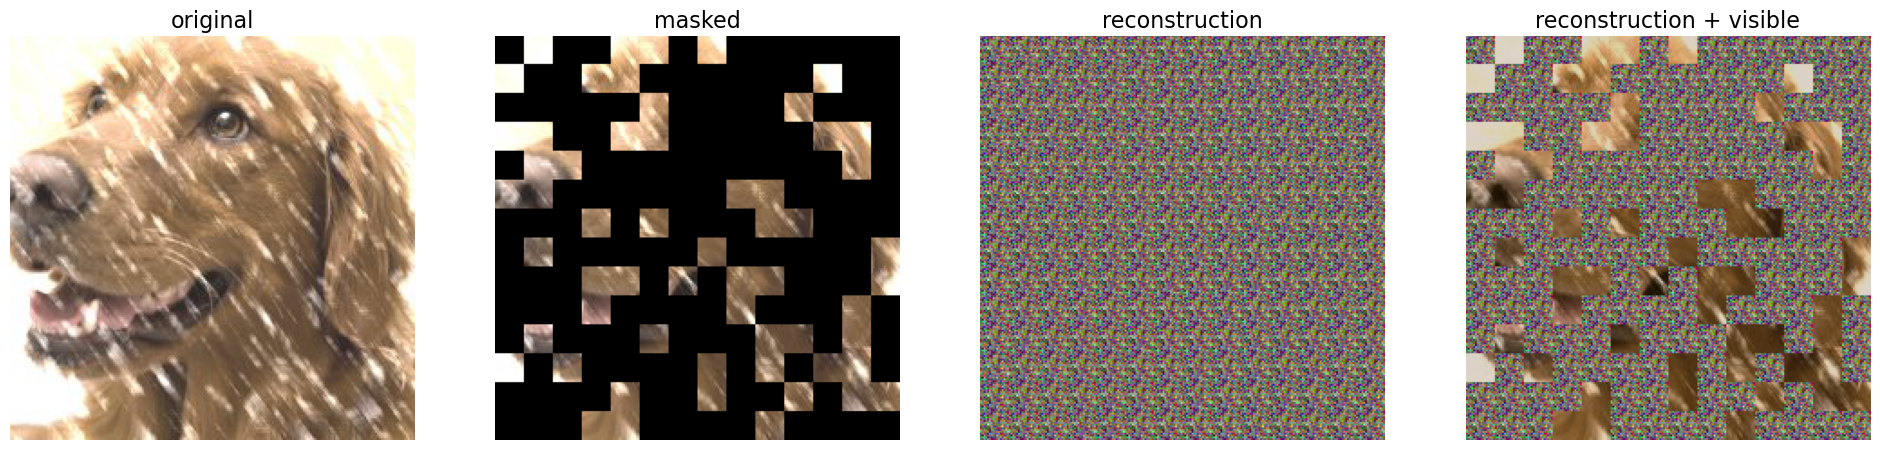

In [10]:
run_one_image(img, model_mae , sigma=sigma, mask_ratio=mask_ratio) #mae based reconstruction

# split dataset

In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = 'data/train/'
val_dir = 'data/val'
test_dir = 'data/test/'

# Replace classifier layer(s)
num_classes = 4  # number of classes in new dataset
model_dmae.decoder_pred = nn.Linear(model_dmae.decoder_pred.in_features, num_classes)
model_dmae.to(device)

train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Create data loaders
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




# previous classification attempts 

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_convmae.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    # Train for one epoch
    model_convmae.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        outputs = model_convmae(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    model_convmae.eval()
    with torch.no_grad():
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model_convmae(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * len(images)
            preds = torch.argmax(outputs, axis=1)
            total_correct += (preds == labels).sum().item()
            total_samples += len(images)

    # Print epoch statistics
    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples
    print(f"Epoch {epoch+1}: val_loss={epoch_loss:.4f} val_acc={epoch_acc:.4f}")

In [52]:
subset_size = 1000  # Number of images in the subset

# Create a subset sampler
subset_sampler = SubsetRandomSampler(range(subset_size))

# Define the dataloader using the subset sampler
batch_size = 4
sub_train = DataLoader(train_dataset, batch_size=batch_size, sampler=subset_sampler)
sub_val = DataLoader(val_dataset, batch_size=batch_size, sampler=subset_sampler)
sub_test = DataLoader(test_dataset, batch_size=batch_size, sampler=subset_sampler)

In [19]:
import util.misc as misc
from timm.utils import accuracy
@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()

    metric_logger = misc.MetricLogger(delimiter="  ")
    header = 'Test:'

    # switch to evaluation mode
    model.eval()

    for batch in metric_logger.log_every(data_loader, 10, header):
        images = batch[0]
        target = batch[-1]
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))

        batch_size = images.shape[0]
        metric_logger.update(loss=loss.item())
        metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
        metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print('* Acc@1 {top1.global_avg:.3f} Acc@5 {top5.global_avg:.3f} loss {losses.global_avg:.3f}'
          .format(top1=metric_logger.acc1, top5=metric_logger.acc5, losses=metric_logger.loss))

    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

In [ ]:

test_stats = evaluate(val_loader, model_convmae, device)
print(f"Accuracy of the network on the {len(val_loader)} test images: {test_stats['acc1']:.1f}%")


In [119]:
import torch
import torch.nn as nn


# Define a separate classifier network
classifier = nn.Sequential(
    nn.Linear(256, 128),  # Input size should match the output size of the MAE
    nn.ReLU(),
    nn.Linear(128, 10),  # Output size should match the number of classes
    nn.LogSoftmax(dim=1)
)

# Set the MAE to evaluation mode to disable dropout and batch normalization
model_dmae.eval()

# Extract representations using the MAE model
def extract_representations(data,mask_ratio):
    representations = []
    labels = []
    for i, (img, label) in enumerate(data):
        if i >= max_images:
            break
        with torch.no_grad():
            img = img.cuda()
            representation, _, _ = model_dmae.forward_encoder(img,mask_ratio)
        representations.append(representation.cpu().numpy()[0])
        labels.append(label.cpu().numpy())
    return np.array(representations), np.array(labels)
mask_ratio = 0.75
max_images = 2000
train_representations, train_labels = extract_representations(train_loader, mask_ratio)
#val_representations, val_labels = extract_representations(val_loader, mask_ratio)
test_representations, test_labels = extract_representations(test_loader, mask_ratio)

In [121]:
print(train_representations.shape)
print(train_labels.shape)

(2000, 50, 1024)
(2000, 1)


In [123]:
from sklearn import svm
clf = svm.SVC()
clf.fit(train_representations.reshape((2000, -1)), train_labels)

# Evaluate the classifier on the testing data
accuracy = clf.score(test_representations.reshape((2000, -1)), test_labels)
print("Accuracy:", accuracy)

c:\Users\txzho\anaconda3\envs\tor\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.782
